In [11]:
import time
import numpy as np
import pandas as pd
import json
import tqdm
import matplotlib.pyplot as plt

## 1. Data Generation

In [12]:
# 2D functions used to compute targets
def sin_sqrt(X):
    return np.sin(np.sqrt(X[:, 0]**2 + X[:, 1]**2))

def booth(X):
    X1, X2 = X[:, 0], X[:, 1]
    return ((X1 + 2*X2 - 7)**2 + (2*X1 + X2 - 5)**2)

def goldstein_price(X):
    X1, X2 = X[:, 0], X[:, 1]
    return ((1+(X1 + X2 + 1)**2*(19-14*X1+3*X1**2-14*X2+6*X1*X2+3*X2**2))*(30+(2*X1-3*X2)**2*(18-32*X1+12*X1**2+48*X2-36*X1*X2+27*X2**2)))

def beale(X):
    X1, X2 = X[:, 0], X[:, 1]
    return (1.5 - X1 + X1*X2)**2 + (2.25 - X1 + X1*X2**2)**2 + (2.625 - X1 + X1*X2**3)**2

# function to generate 2D input data
def generate_X(n_samples, ranges=[(0, 1), (0, 1)], random_state=None):
    dim = len(ranges)
    assert dim > 0
    rng = np.random.default_rng(random_state)
    X = np.zeros((n_samples, dim))
    for i, r in enumerate(ranges):
        low, high = r
        X[:, i] = rng.uniform(low, high, n_samples)
    return X

In [13]:
# generate datasets
seed = 42
n_samples = 10000
features = dict(
    sin_sqrt=generate_X(n_samples, ranges=[(-5, 5), (-5, 5)], random_state=seed),
    booth=generate_X(n_samples, ranges=[(-10, 10), (-10, 10)], random_state=seed),
    goldstein_price=generate_X(n_samples, ranges=[(-2, 2), (-2, 2)], random_state=seed),
    beale=generate_X(n_samples, ranges=[(-4.5, 4.5), (-4.5, 4.5)], random_state=seed)
)

targets = dict(
    sin_sqrt=sin_sqrt(features['sin_sqrt']),
    booth=booth(features['booth']),
    goldstein_price=goldstein_price(features['goldstein_price']),
    beale=beale(features['beale'])
)

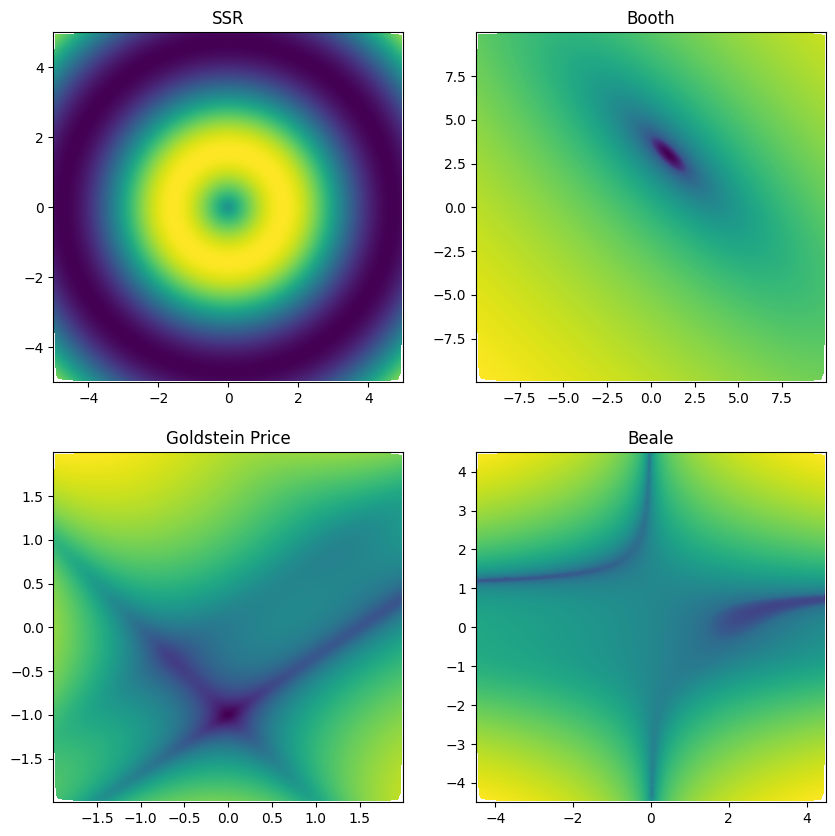

In [14]:
from matplotlib import colors
from scipy.interpolate import griddata

fn_map = dict(
    goldstein_price="Goldstein Price",
    booth="Booth",
    beale="Beale",
    sin_sqrt="SSR"
)

def plot_as_heatmap(ax, fig, x, y, z, n_points=100, cmap="viridis", norm="symlog", interpolation="cubic"):
    x_min, x_max = min(x), max(x)
    y_min, y_max = min(y), max(y)
    X, Y = np.meshgrid(np.linspace(x_min, x_max, n_points), np.linspace(y_min, y_max, n_points))
    Z = griddata((x, y), z, (X, Y), method=interpolation)
    pcm = ax.imshow(Z, extent=[x_min, x_max, y_min, y_max], origin="lower", cmap=cmap, norm=norm)
    return pcm

n_fns = len(targets)
n_rows = 2
height = 5
fig = plt.figure(figsize=(height*n_rows, height*n_rows))
for idx, fn in enumerate(features):
    ax = fig.add_subplot(n_rows, n_fns//n_rows, idx+1)
    pcm = plot_as_heatmap(ax, fig, features[fn][:, 0], features[fn][:, 1], targets[fn], n_points=1000)
    ax.set_title(fn_map[fn])
plt.show()

## 2. Preprocessing

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

train = {}
test = {}
scalers = {}
for k in features:
    X_train, X_test, y_train, y_test = train_test_split(features[k], targets[k], test_size=0.2)
    train[k] = (X_train, y_train)
    test[k] = (X_test, y_test)
    scalers[k] = MinMaxScaler((-1, 1))
    scalers[k].fit(X_train)
scalers

{'sin_sqrt': MinMaxScaler(feature_range=(-1, 1)),
 'booth': MinMaxScaler(feature_range=(-1, 1)),
 'goldstein_price': MinMaxScaler(feature_range=(-1, 1)),
 'beale': MinMaxScaler(feature_range=(-1, 1))}

## 3. Training

### 3.1 K-Fold Cross-Validation Comparison

In [16]:
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, cross_validate
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, mean_absolute_error
from mas import context
from mas import head


# loading best params for benchmark algorithms
with open("best_params.json", "r") as f:
    best_params = json.load(f)

best_params["mas"] = dict(
    sin_sqrt=dict(
        R=np.full(2, 0.1),
        alpha=0.4,
        bad_th=0.2,
        imprecise_th=0.01,
        memory_length=20,
        min_vol=0.
    ),
    booth=dict(
        R=np.full(2, 0.35),
        alpha=0.1,
        bad_th=0.2,
        imprecise_th=0.15,
        memory_length=50,
        min_vol=0.
    ),
    goldstein_price=dict(
        R=np.full(2, 0.1),
        alpha=0.1,
        bad_th=0.2,
        imprecise_th=0.01,
        memory_length=200,
        min_vol=0.
    ),
    beale=dict(
        R=np.full(2, 0.05),
        alpha=0.2,
        bad_th=0.3,
        imprecise_th=0.1,
        memory_length=20,
        min_vol=0.
    ),
)

# initialize models from best params:
models_cls = dict(
    xgboost=XGBRegressor,
    lightbgm=LGBMRegressor,
    random_forest=RandomForestRegressor,
    decision_tree=DecisionTreeRegressor,
    linear_regression=LinearRegression,
    gradient_boosting=GradientBoostingRegressor,
    svr=SVR,
    mas=head.FastHeadAgent
)
models = {}
for k in best_params:
    models_by_fn = {}
    algo = models_cls[k]
    for fn, params in best_params[k].items():
        models_by_fn[fn] = algo(**params)
    models[k] = models_by_fn
models.keys()

dict_keys(['xgboost', 'lightbgm', 'random_forest', 'decision_tree', 'linear_regression', 'gradient_boosting', 'svr', 'mas'])

In [17]:
# evaluate cross validation score
cross_val_results = {}
scoring = {
    'r2': make_scorer(r2_score),
    'mse': make_scorer(mean_squared_error),
    'mae': make_scorer(mean_absolute_error)
}
pbar = tqdm.tqdm(models)
for m in pbar:
    res = {}
    for fn, model in models[m].items():
        pbar.set_description(f"[{m} - {fn}]")
        X_train, y_train = train[fn]
        score = cross_validate(model, scalers[fn].transform(X_train), y_train, cv=5, scoring=scoring, return_estimator=True, n_jobs=-1)
        res[fn] = score
    cross_val_results[m] = res

[mas - beale]: 100%|██████████| 8/8 [28:16<00:00, 212.03s/it]                       


In [18]:
from pprint import pprint

scores = {k: v for k,v in cross_val_results.items()}
scores = {k: {fn: {metric: values.mean() for metric, values in m.items() if metric.startswith("test_")} for fn, m in v.items()} for k,v in scores.items()}
results_df = pd.DataFrame.from_dict({(outerKey, innerKey): values for outerKey, innerDict in scores.items() for innerKey, values in innerDict.items()}, orient='index')
results_df = results_df.swaplevel().sort_index()
results_df

test_r2      test_mse      test_mae
beale           decision_tree      0.982783  6.849292e+06   1054.043885
                gradient_boosting  0.994302  2.276605e+06    618.819761
                lightbgm           0.995959  1.615642e+06    464.498572
                linear_regression -0.001056  4.005585e+08  11677.028977
                mas                0.996947  1.236707e+06    245.863152
                random_forest      0.995049  1.972340e+06    524.693248
                svr               -0.138006  4.553203e+08   8108.010879
                xgboost            0.996924  1.236221e+06    410.377760
booth           decision_tree      0.993174  1.322623e+03     26.155237
                gradient_boosting  0.999351  1.254376e+02      7.228328
                lightbgm           0.999335  1.291103e+02      7.861507
                linear_regression  0.417507  1.130465e+05    257.600826
                mas                0.999947  1.022580e+01      1.011399
                random_forest      0.998157  3.575795e+02     13.032082
                svr                0.809930  3.713528e+04     76.115741
                xgboost            0.999573  8.312282e+01      5.873713
goldstein_price decision_tree      0.993449  1.075731e+08   5306.392190
                gradient_boosting  0.998677  2.152487e+07   2535.121135
                lightbgm           0.998827  1.927842e+07   1842.669826
                linear_regression  0.247359  1.230160e+10  68462.687180
                mas                0.992680  1.294442e+08    937.932518
                random_forest      0.997560  3.959502e+07   3353.565271
                svr               -0.128736  1.851219e+10  52103.577580
                xgboost            0.999047  1.580639e+07   1633.014479
sin_sqrt        decision_tree      0.961479  1.836054e-02      0.091699
                gradient_boosting  0.997442  1.219174e-03      0.022557
                lightbgm           0.998472  7.282119e-04      0.019219
                linear_regression -0.001509  4.772788e-01      0.609803
                mas                0.998876  5.358906e-04      0.013984
                random_forest      0.978473  1.025834e-02      0.065913
                svr                0.973390  1.268276e-02      0.078665
                xgboost            0.998660  6.390402e-04      0.016884

### 3.2 Comparing predictions

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# evaluate on test data
results = dict()

for fn in test:
    X_test, y_test = test[fn]
    res = {}
    for m in models:
        model = models[m][fn]
        y_pred = model.predict(scalers[fn].transform(X_test))
        mse = mean_squared_error(y_pred, y_test)
        mae = mean_absolute_error(y_pred, y_test)
        r2 = r2_score(y_pred, y_test)
        res[m] = dict(
            mse=mse, 
            mae=mae,
            r2=r2,
        )
    results[fn] = res

results_df = pd.DataFrame.from_dict({(outerKey, innerKey): values for outerKey, innerDict in results.items() for innerKey, values in innerDict.items()}, orient='index')
results_df

NotFittedError: need to call fit or load_model beforehand

In [ ]:
ms = ["mas", "xgboost", "lightbgm"]
n_models = len(ms)
n_fns = len(test)
height = 6
width = 5
n_cols = n_models + 1
n_rows = n_fns

fig = plt.figure(figsize=(height * n_cols, width * n_rows), layout="constrained")
plt_idx = 0
for fn in test:
    X_test, y_test = test[fn]
    v_min, v_max = np.round(y_test.min()), np.round(y_test.max())
    
    for m in ms:
        plt_idx += 1
        y_pred = models[m][fn].predict(scalers[fn].transform(X_test))
        ax = fig.add_subplot(n_cols, n_rows, plt_idx)
        pcm_ = plot_as_heatmap(ax, fig, X_test[:, 0], X_test[:, 1], y_pred, n_points=1000, interpolation="linear")
        pcm_.set_clim(vmin=v_min, vmax=v_max)
        ax.set_title(f"prediction {m}")
    fig.colorbar(pcm_)
    
    plt_idx += 1